In [1]:
# Data analysis imports
import pandas as pd
import numpy as np
import time

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Model building imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Evaluation imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Model interpretation imports
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import shap

In [159]:
# Loading training and test data
trainData = pd.read_csv('train.csv', index_col=0).reset_index(drop=True)
testData = pd.read_csv('test.csv')

In [3]:
# Looking at first 5 rows
trainData.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1151,1,2.9,1,0,0,31,0.6,128,8,...,1022,1560,2377,18,8,13,0,1,0,2
1,1065,0,1.7,1,4,1,48,0.3,162,6,...,1188,1948,265,8,0,12,1,0,0,0
2,1375,0,2.9,0,2,0,20,0.4,147,6,...,596,679,3847,8,0,12,1,0,1,3
3,1329,1,1.0,0,1,0,52,0.9,181,6,...,1053,1458,1228,8,6,6,1,0,1,1
4,1521,1,1.6,0,5,1,62,0.3,143,1,...,678,1630,3555,5,2,19,1,0,0,3


In [160]:
testData.head()

,Unnamed: 0,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1021,1,0.5,1,0,1,53,0.7,136,...,6,905,1988,2631,17,3,7,1,1,0
1,2,563,1,0.5,1,2,1,41,0.9,145,...,6,1263,1716,2603,11,2,9,1,1,0
2,6,1821,0,1.7,0,4,1,10,0.8,139,...,10,381,1018,3220,13,8,18,1,0,1
3,9,509,1,0.6,1,2,1,9,0.1,93,...,15,1137,1224,513,19,10,12,1,0,0
4,17,595,0,0.9,1,7,1,23,0.1,121,...,17,441,810,3752,10,2,18,1,1,0


## Data Exploration

In [20]:
# Looking at df.info() to see the data types of all columns, understand what variables are numerical and which are categorical
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1500 non-null   int64  
 1   blue           1500 non-null   int64  
 2   clock_speed    1500 non-null   float64
 3   dual_sim       1500 non-null   int64  
 4   fc             1500 non-null   int64  
 5   four_g         1500 non-null   int64  
 6   int_memory     1500 non-null   int64  
 7   m_dep          1500 non-null   float64
 8   mobile_wt      1500 non-null   int64  
 9   n_cores        1500 non-null   int64  
 10  pc             1500 non-null   int64  
 11  px_height      1500 non-null   int64  
 12  px_width       1500 non-null   int64  
 13  ram            1500 non-null   int64  
 14  sc_h           1500 non-null   int64  
 15  sc_w           1500 non-null   int64  
 16  talk_time      1500 non-null   int64  
 17  three_g        1500 non-null   int64  
 18  touch_sc

#### Observations:
 - df.info() reveals that all columns are numerical, need to dig a little deeper to confirm this, will look into the distributions of the features

In [64]:
# Finding if there are any missing values in the data
trainData.isna().any()

battery_power    False
blue             False
clock_speed      False
dual_sim         False
fc               False
four_g           False
int_memory       False
m_dep            False
mobile_wt        False
n_cores          False
pc               False
px_height        False
px_width         False
ram              False
sc_h             False
sc_w             False
talk_time        False
three_g          False
touch_screen     False
wifi             False
price_range      False
dtype: bool

#### Observations:
- The output shows that no column has missing values, no missing value treatment needed.

In [23]:
trainData.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,1230.742000,0.508000,1.536867,0.519333,4.361333,0.526667,32.067333,0.500133,140.582667,4.513333,...,654.626667,1263.805333,2113.516000,12.293333,5.797333,10.860667,0.763333,0.506667,0.510667,1.488000
std,440.517687,0.500103,0.810246,0.499793,4.367549,0.499455,18.179598,0.285799,35.535762,2.304784,...,441.496076,428.900661,1079.558518,4.179346,4.366956,5.506614,0.425178,0.500122,0.500053,1.118342
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,838.750000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,299.750000,888.750000,1210.750000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.000000
50%,1209.000000,1.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,585.000000,1262.000000,2102.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.000000
75%,1611.750000,1.000000,2.300000,1.000000,7.000000,1.000000,48.000000,0.800000,171.000000,7.000000,...,952.250000,1643.500000,3056.250000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.000000
max,1998.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1997.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [65]:
# Segregating continuous, binary and target variable
target_variable = 'price_range'
binary_variables = ['wifi', 'three_g', 'touch_screen', 'blue', 'dual_sim', 'four_g']
continuous_variables = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', ]

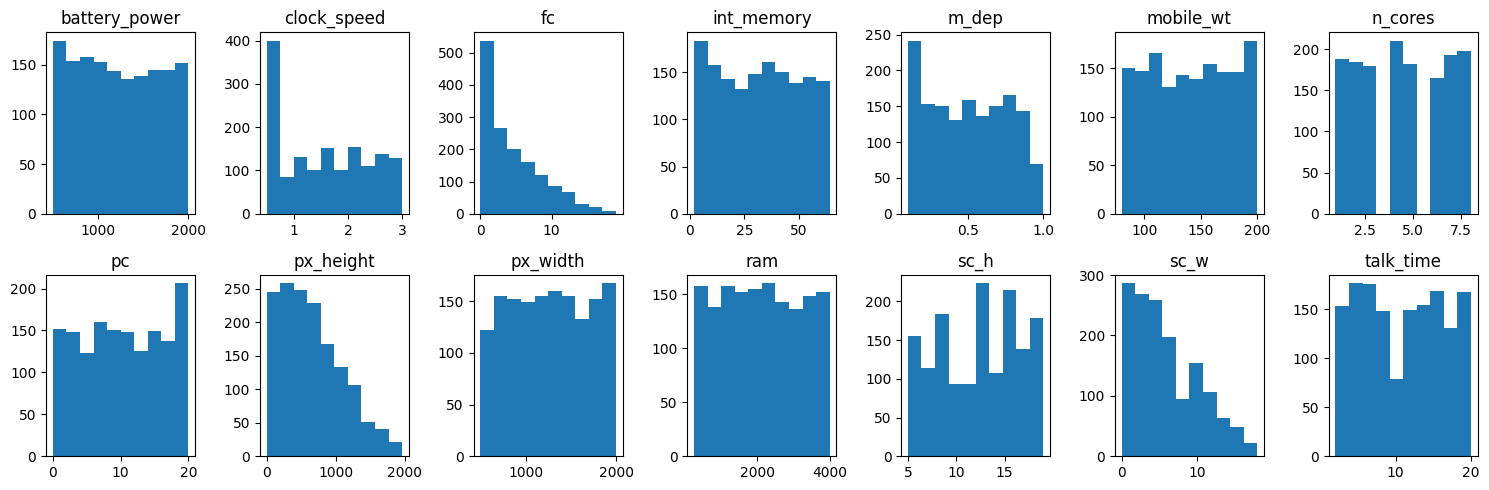

In [66]:
# Generating histogram for continuous variables to see what scaling method will be good
fig, ax = plt.subplots(2, 7, figsize = (15,5))
for i in range(0,7):
    ax[0, i].hist(trainData[continuous_variables[i]])
    ax[0, i].set_title(continuous_variables[i])
    ax[1, i].hist(trainData[continuous_variables[i+7]])
    ax[1, i].set_title(continuous_variables[i+7])
plt.tight_layout()
plt.show()

#### Observations:
- All the distributions are not normal, so StandardScaler cannot be used as it works well on normal distributions
- There are no outliers as well in the data, so MinMaxScaler will work well

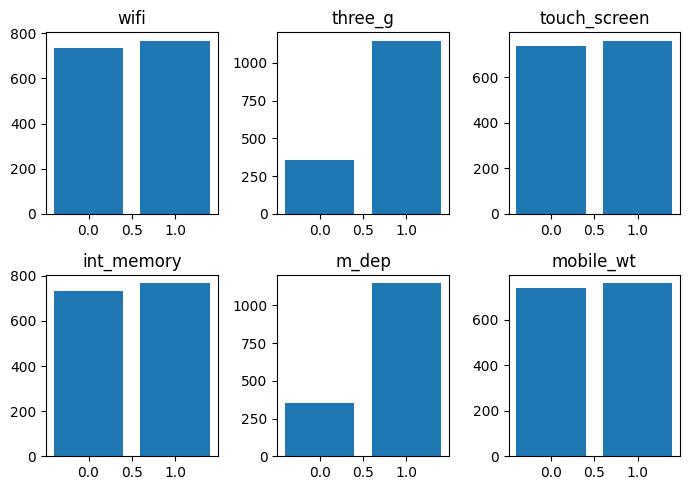

In [87]:
# Generating bar plots for binary variables to see the distribution
fig, ax = plt.subplots(2, 3, figsize = (7,5))
for i in range(0,3):
    ax[0, i].bar(trainData[binary_variables[i]].value_counts().index.tolist(), trainData[binary_variables[i]].value_counts().values)
    ax[0, i].set_title(binary_variables[i])
    ax[1, i].bar(trainData[binary_variables[i]].value_counts().index.tolist(), trainData[binary_variables[i]].value_counts().values)
    ax[1, i].set_title(continuous_variables[i+3])
plt.tight_layout()
plt.show()

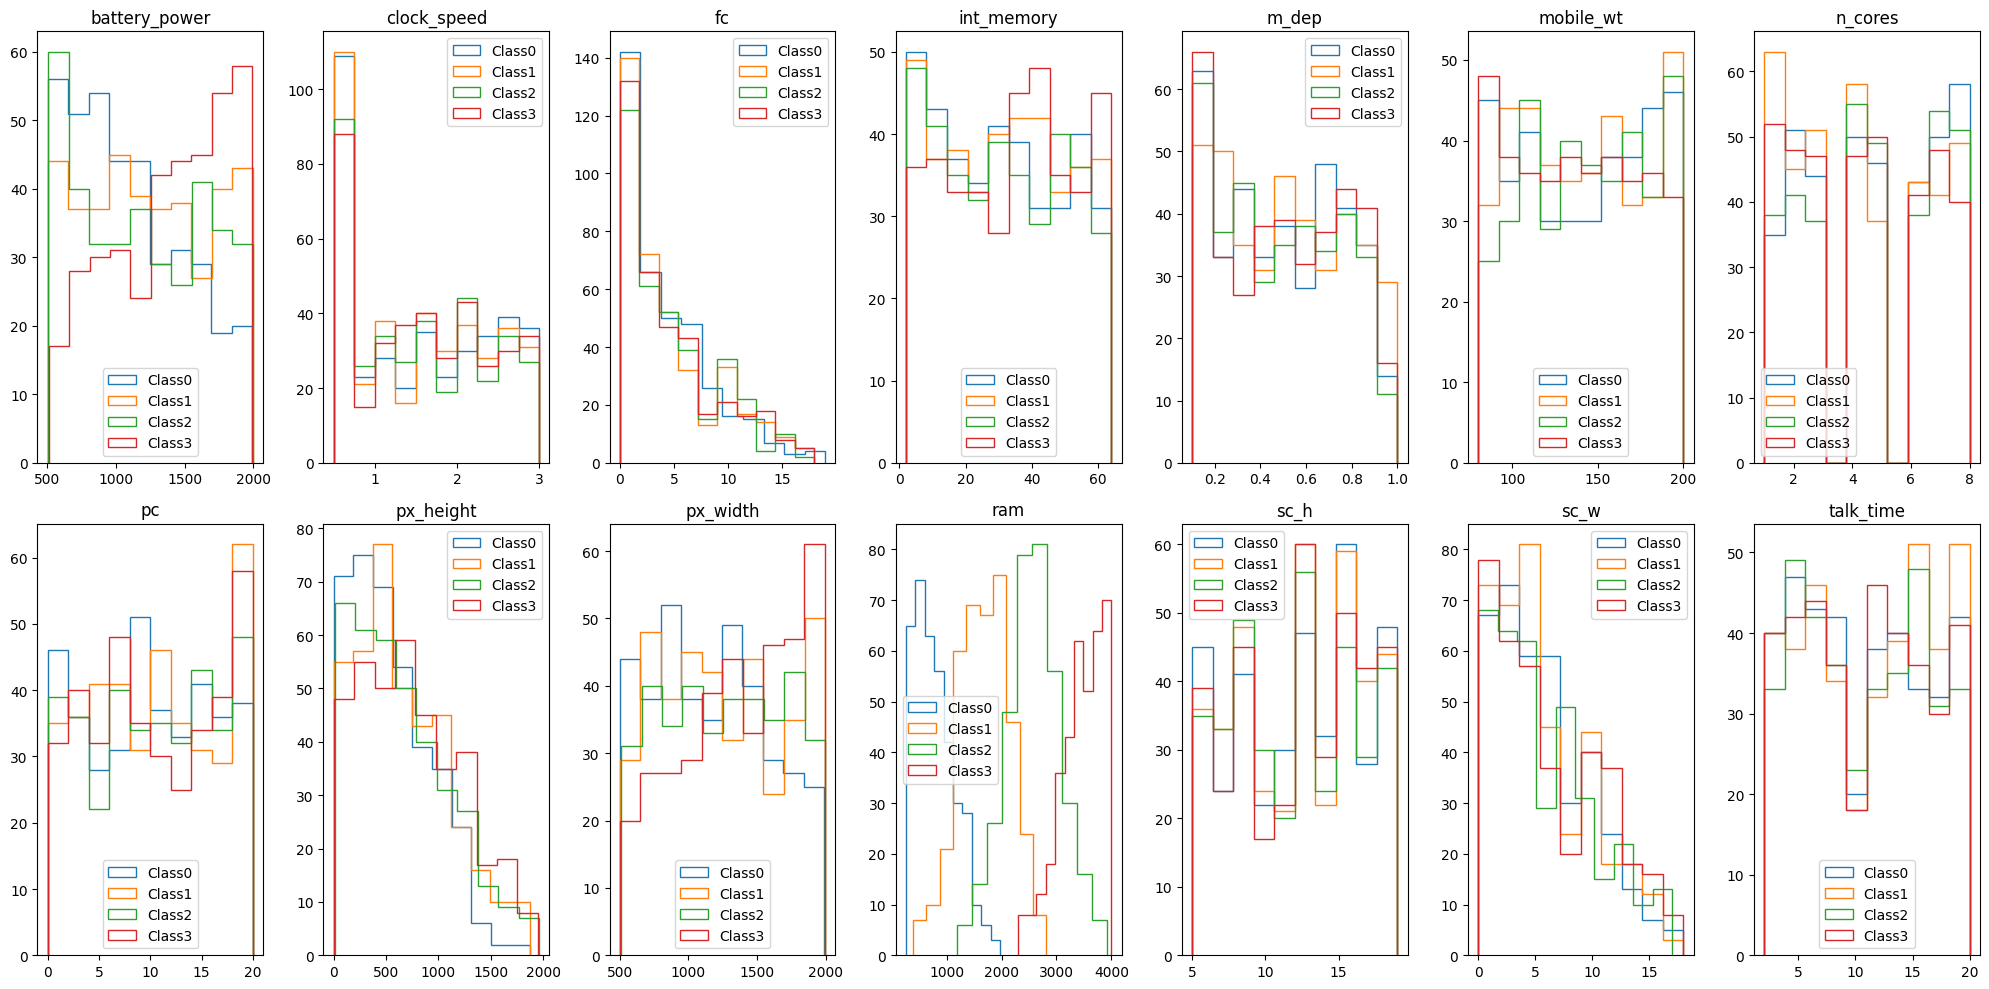

In [86]:
## Generating histogram for continuous variables stratified by 'price_range' to see what variables distributions are different across classes
fig, ax = plt.subplots(2, 7, figsize = (20,10))
for j in [0, 1]:
    for i in range(0, 7):
        if j == 1:
            n=7
        else:
            n=0
        ax[j, i].hist(trainData[trainData['price_range']==0][continuous_variables[i+n]], label='Class0', histtype='step')
        ax[j, i].hist(trainData[trainData['price_range']==1][continuous_variables[i+n]], label='Class1', histtype='step')
        ax[j, i].hist(trainData[trainData['price_range']==2][continuous_variables[i+n]], label='Class2', histtype='step')
        ax[j, i].hist(trainData[trainData['price_range']==3][continuous_variables[i+n]], label='Class3', histtype='step')
        ax[j, i].set_title(continuous_variables[i+n])
        ax[j, i].legend()
plt.tight_layout()
plt.show()

#### Observations:
- 'ram', 'battery_power' and 'px_width' have quite different distributions across classes. Let's see if the model is also able to capture this.
- Other than the 3 variables mentioned above, 'pc', 'px_height' and 'mobile_wt' may also help in segregating classes.

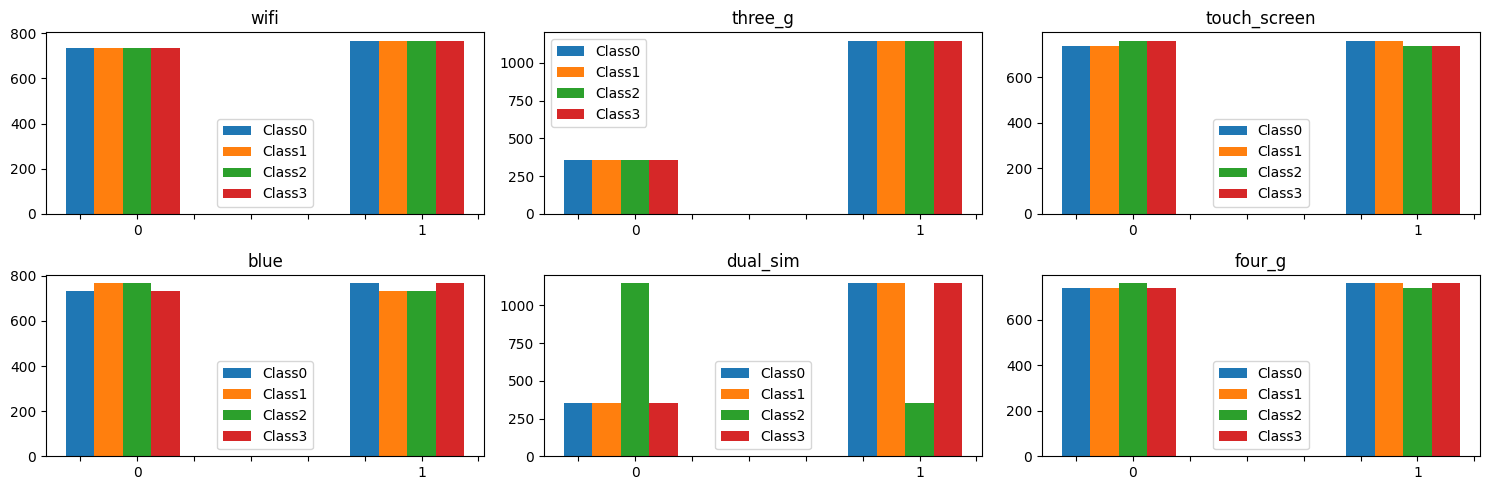

In [107]:
# Generating bar plots for binary variables to see the distribution
width = 0.1
add_arr = np.array([width])
fig, ax = plt.subplots(2, 3, figsize = (15,5))
for j in [0, 1]:
    for i in range(0,3):
        if j == 1:
            n=3
        else:
            n=0
        ax[j, i].bar(np.array(trainData[trainData['price_range']==0][binary_variables[i+n]].value_counts().index.tolist()), trainData[binary_variables[i]].value_counts().values, width=width, label='Class0')
        ax[j, i].bar(np.array(trainData[trainData['price_range']==1][binary_variables[i+n]].value_counts().index.tolist()) + add_arr, trainData[binary_variables[i]].value_counts().values, width=width, label='Class1')
        ax[j, i].bar(np.array(trainData[trainData['price_range']==2][binary_variables[i+n]].value_counts().index.tolist()) + (2*add_arr), trainData[binary_variables[i]].value_counts().values, width=width, label='Class2')
        ax[j, i].bar(np.array(trainData[trainData['price_range']==3][binary_variables[i+n]].value_counts().index.tolist()) + (3*add_arr), trainData[binary_variables[i]].value_counts().values, width=width, label='Class3')
        ax[j, i].set_title(binary_variables[i+n])
        ax[j, i].legend()
        ax[j, i].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4], ['', '0', '', '', '', '', '1', ''])
plt.tight_layout()
plt.show()

#### Observations:
- For most of the variables, the distribution of 0s and 1s is similar across classes so they are not adding much variation to the data
- The only variable which has little variation is 'dual_sim' but only for 'price_range' 2 vs others

In [69]:
# Exploring target variable to see if the classes are balanced
trainData['price_range'].value_counts()

price_range
1    387
0    377
3    373
2    363
Name: count, dtype: int64

#### Observations:
- The output shows that the classes are balanced, so no techniques need to be implemented to balance classes and accuracy can be used to evaluate the model

## Model Building

## Train test split
Since the test data provided doesn't have the target variable, creating a small test set to test the model

In [125]:
# Extracting inputs and output
XTrain = trainData.drop(columns = ['price_range'])
yTrain = trainData['price_range'].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(XTrain, yTrain, test_size=0.2, random_state=42, stratify=yTrain)

## Feature Scaling
As all the continuous variables do not have normal distribution and no outliers, min max scaling is a good option to scale the features

In [126]:
# Define a column transformer to scale the continuous varaibels, and passing continuous 
ct = ColumnTransformer([("preprocess", MinMaxScaler(), continuous_variables)], remainder="passthrough")
# Fit the transformer to training data
X_train_scaled = ct.fit_transform(X_train)
# Saving the oreder of columns for future use
columns=ct.get_feature_names_out()

In [127]:
columns

array(['preprocess__battery_power', 'preprocess__clock_speed',
       'preprocess__fc', 'preprocess__int_memory', 'preprocess__m_dep',
       'preprocess__mobile_wt', 'preprocess__n_cores', 'preprocess__pc',
       'preprocess__px_height', 'preprocess__px_width', 'preprocess__ram',
       'preprocess__sc_h', 'preprocess__sc_w', 'preprocess__talk_time',
       'remainder__blue', 'remainder__dual_sim', 'remainder__four_g',
       'remainder__three_g', 'remainder__touch_screen', 'remainder__wifi'],
      dtype=object)

## Hyperparameter tuning

In [128]:
# Defining hyperparamete space
params = {
    'n_estimators':[100, 120, 150, 200],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],
    'learning_rate': [0.1, 0.2, 0.3, 0.05, 0.06, 0.08, 0.09],
    'alpha': [0, 1, 2, 4, 6],
    'lambda': [1, 2, 4, 6, 8],
    'eval_metric': ['merror', 'mlogloss'],
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7]
}

In [129]:
# Defining the classifier and random search parameters
clf = XGBClassifier(objective = 'multi:softprob')
n_iter_search = 100
random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=n_iter_search, cv=5, scoring='accuracy')

In [130]:
start = time.time()
random_search.fit(X_train_scaled, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 113.86 seconds for 100 candidates parameter settings.


In [131]:
best_params = random_search.best_params_

In [132]:
best_params

{'subsample': 0.6,
 'n_estimators': 200,
 'min_child_weight': 4,
 'max_depth': 4,
 'learning_rate': 0.3,
 'lambda': 1,
 'gamma': 0.4,
 'eval_metric': 'mlogloss',
 'colsample_bytree': 1.0,
 'alpha': 0}

In [133]:
# Fit the model on entire training dataset with the best hyperparameters
clf = XGBClassifier(objective = 'multi:softprob', **best_params)
clf.fit(X_train_scaled, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, ...)

In [114]:
# Calculating performance of model on the test set, although accuracy is enough to gauge the performance because of balanced classes but let's 
# calculate precision, recall and f1 as these are important metrics

In [119]:
performance_df = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1'])

In [134]:
#Prepare test data to make predictions
X_test_scaled = ct.transform(X_test)
# Make predictions
y_pred = clf.predict(X_test_scaled)

In [135]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
# Precison recall and f1
# Using 'weighted' method, however all the methods 'macro', 'micro' will give the same results as classes are balanced
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
metrics = [acc, prec, rec, f1]

In [140]:
for i in range(4):
    performance_df.loc[performance_df.index[i], 'Percentage'] = round(metrics[i]*100, 2)

In [141]:
performance_df

,Percentage
Accuracy,92.67
Precision,92.95
Recall,92.67
F1,92.65


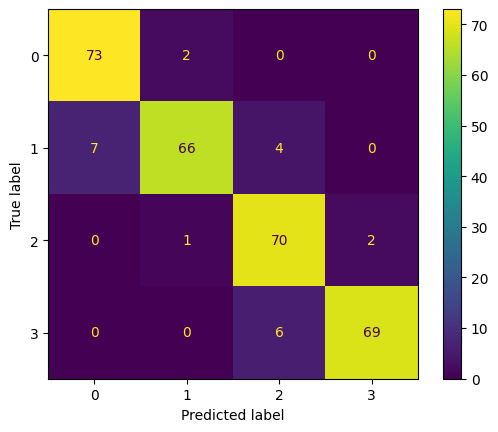

In [142]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Observations:
- Confusion matrix shows most of the samples are correctly classified. 'price_range' 0 has the least misclassified samples

In [143]:
# Using entire training data to fit the mode, combining the test set as well
XTrainScaled = ct.fit_transform(XTrain)
clf = XGBClassifier(objective = 'multi:softprob', **best_params)
clf.fit(XTrainScaled, yTrain)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, ...)

## Prediction on test data provided 

In [161]:
testData.columns

Index(['Unnamed: 0', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc',
       'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [162]:
test_pred_df = pd.DataFrame()

In [164]:
test_pred_df['id'] = testData['Unnamed: 0']
# Dropping 'id' column 
testClean = testData.drop(columns = ['Unnamed: 0'])
# Transform data
test_scaled = ct.transform(testClean)
test_pred = clf.predict(test_scaled)
test_pred_df['price_range'] = test_pred

In [165]:
test_pred_df.to_csv('testPredictions.csv', index=False)

## Model Interpretation (feature importance)

### xgboost feature importance methods

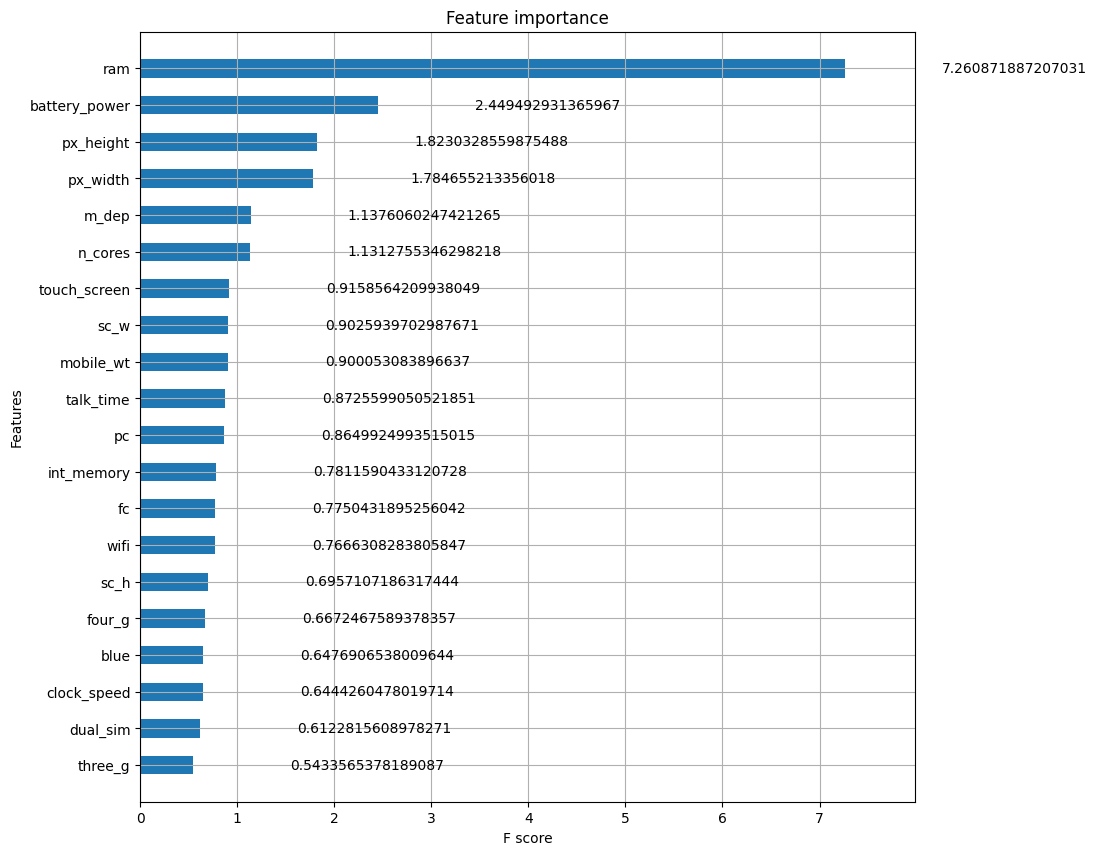

In [144]:
# Using columns generated from column transformer and removing prefixes
clean_columns = [i.split('__')[-1] for i in columns]
fig, ax = plt.subplots(figsize=(10,10))
clf.get_booster().feature_names = clean_columns
xgb.plot_importance(clf, height=0.5, ax=ax, importance_type='gain')
plt.show()

#### Observations:
- As can be seen, top 5 variables which are the most important are 'ram', 'battery_power', 'px_height', 'px_width' and 'm_dep'
- 'ram', 'battery_power', 'px_height', 'px_width' were also identified in exploratory analysis as adding most variation in the data
- In all, it can be said that results of feature importance largely align with exploratory data analysis done

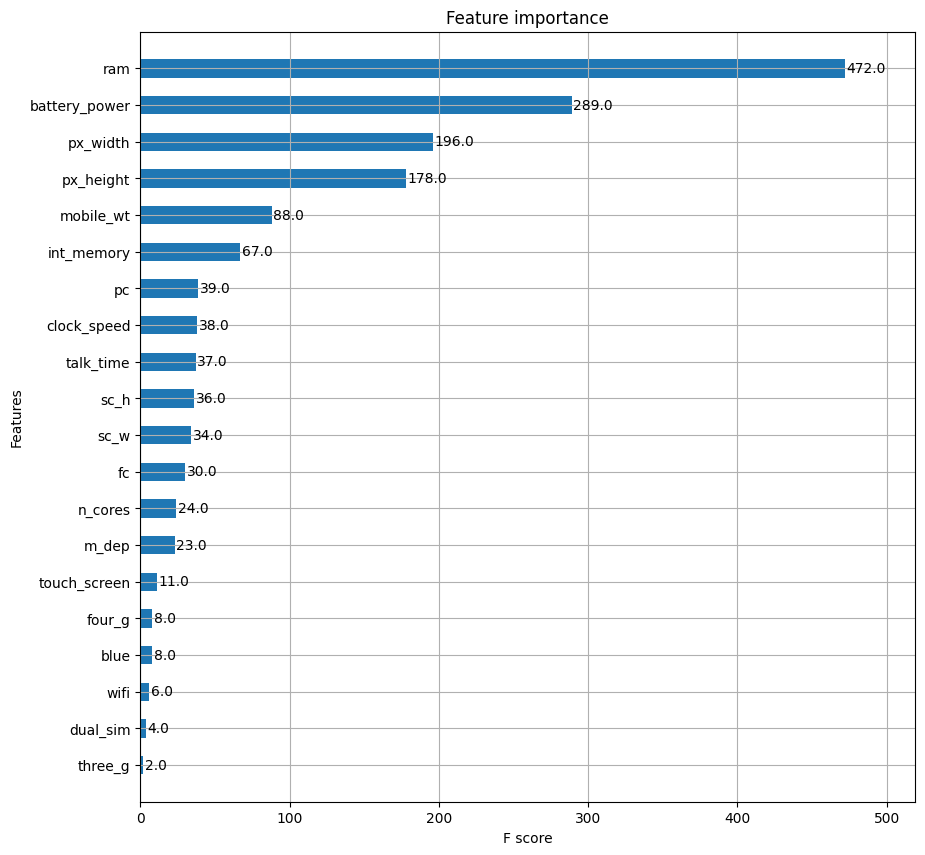

In [146]:
fig, ax = plt.subplots(figsize=(10,10))
clf.get_booster().feature_names = clean_columns
xgb.plot_importance(clf, height=0.5, ax=ax, importance_type='weight')
plt.show()

#### Observations:
- In this method of feature importance as well, first 4 variables are the same, only difference is 'mobile_wt' variable

### SHAP method

In [149]:
X_train_scaled_df = pd.DataFrame(XTrainScaled, columns=clean_columns)

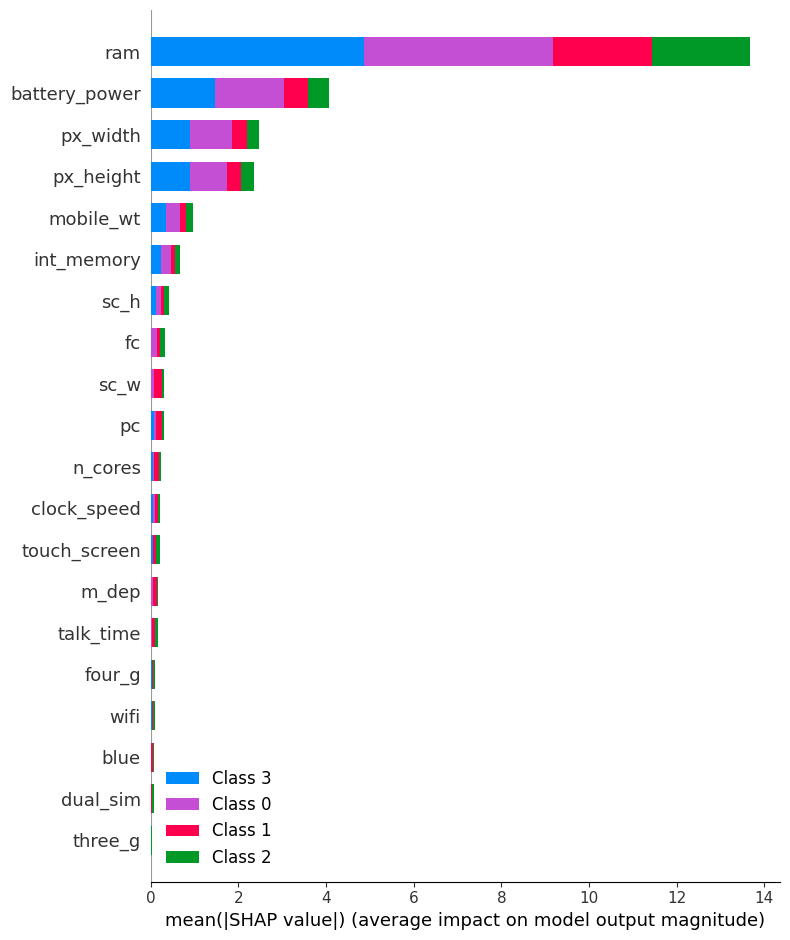

In [150]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train_scaled_df)
shap_values = [shap_values[:,:,i] for i in range(shap_values.shape[-1])]
shap.summary_plot(shap_values, X_train_scaled_df, plot_type='bar')

#### Observations:
- Shap is also giving the same results as given xgboost feature importance
- In all, 'ram', 'battery_power', 'px_height', 'px_width' are the most important variables according to the results

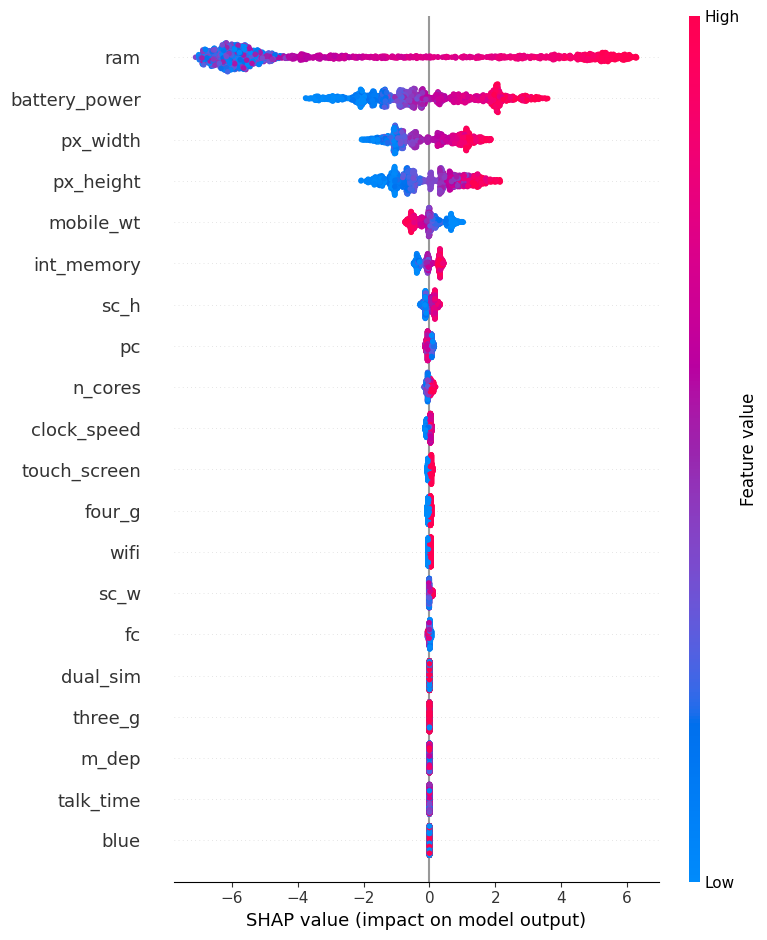

In [154]:
# Taking a look at shap values for a class
shap.summary_plot(shap_values[3], X_train_scaled_df)

Observations:
- As can be seen, 'ram' has the most impact on model output across all samples, followed by 'battery_power', 'px_width' and 'px_height.
- Also, for sample where 'ram' matters, it has a very high impact